In [1]:
import csv
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import json
from scipy.interpolate import interp1d
from scipy.interpolate import PPoly

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from pyslabgrid import slabrup as slabrup
from pyslabgrid import circ as circ

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
};

<IPython.core.display.Javascript object>

#### Note
The depth analyses does not use dip-angle to decide the strike-orientations. Instead, we apply depth = 80 km for Hikurangi and 0 km for Puysegur, as threshold depths to decide whether strike is aligned with slab (dip-direction is same as slab) or the other way round.  See the paradigm in the workout-sdrp-slabrupgeom-summary

In [3]:
# for more rigourous classification of strikes
dump_hik = slabrup.get_GeoNetevents('hik')
dump_puy = slabrup.get_GeoNetevents('puy')
slabevents = {'hik': dump_hik, 'puy': dump_puy}


In [4]:
def circ_median(data):
    data = [np.deg2rad(d) for d in data]
    mcos = np.median(np.cos(data))
    msin = np.median(np.sin(data))
    M = np.rad2deg(np.arctan2(msin, mcos))
    if M<0:
        M= 360+M
    return (M)

def abs_circ_diff(a,b):
    return abs(((a-b)+180)%360-180)

def circ_median_absolution_deviation(data):
    M = circ_median(data)
    diffs = []
    for d in data:
        diffs.append(abs_circ_diff(d,M))
    
    return(np.median(diffs))

def circ_add(a,b):
    return (a+b)%360

def circ_diff(a,b):
    return (((a-b)+180)%360-180)

def get_cmedian_stats(dat):
    return (round(circ_median(dat),1), \
            round(circ_median_absolution_deviation(dat),2))

In [5]:
def get_fmodel_data (szone, slabevents):
    bangle = 45
    lon, lat = slabevents[szone]['lon'], slabevents[szone]['lat']
    strike1 = slabevents[szone]['strike1']
    strike2 = slabevents[szone]['strike2']
    rake1 = slabevents[szone]['rake1']
    rake2 = slabevents[szone]['rake2']
    dip1 = slabevents[szone]['dip1']
    dip2 = slabevents[szone]['dip2']
    dep = slabevents[szone]['dep']
    
    finterp_file = {'hik': '../subduction-model/finterp/hik_finterp.npy', 
                    'puy': '../subduction-model/finterp/puy_finterp.npy',}
    
    finterp = np.load(finterp_file[szone], allow_pickle=True)[()]
    slabstrike_finterp = finterp['strikeAn']

    fbs = 10
    cdep = {'hik': 80, 'puy': 0}
    if szone=='hik':
        depbin = [x for x in range(20,250,fbs)]
    else:
        depbin = [x for x in range(20,250,fbs)]

    fmodel_data = {}
    for db in depbin:
        mystrike, mydip, myrake, mydep = [], [], [], []
    
        for x,y, s1,r1,dp1, s2,r2,dp2,z \
            in zip(lon, lat, strike1,rake1,dip1, strike2,rake2,dip2, dep):
        #
            if (z>=db-fbs) & (z<=db+fbs):
                kslabstrike = slabstrike_finterp(np.transpose([[x],[y]]))[0]
                if db>cdep[szone]:
                    kstrike = (kslabstrike-180)%360
                else:
                    kstrike = kslabstrike
            
                abs_cric_diff = abs_circ_diff(s1,kstrike)
                abs_cric_diff2 = abs_circ_diff(s2,kstrike) 
                if abs_cric_diff< bangle:
                    mystrike.append(s1)
                    mydip.append(dp1)
                    myrake.append(r1)
                    mydep.append(z)
                elif abs_cric_diff2 < bangle:
                    mystrike.append(s2)
                    mydip.append(dp2)
                    myrake.append(r2)
                    mydep.append(z)    
         
        if mystrike:     
            cmed, cmad = circ.meanstats(mystrike, high=360, stdev=True)
            fmodel_data.update({db: {'strike': mystrike, 'rake': myrake, 'dip': mydip, 'dep': mydep}})
    return fmodel_data


In [6]:
 def plot_params_depthbins(depbins, m_params, merr_params, \
                              xlab = 'strike', ylim = [0,360], ax = None, interpmod=False):
        #
        ax.errorbar(depbins, m_params, yerr = merr_params, color='k', \
             linewidth= 1,linestyle='None', capsize=5);
        if interpmod:
            ax.plot(depbins, m_params,'o', markersize=10, color='grey')
        else:
            ax.plot(depbins, m_params,'o', markersize=10, color='maroon')
        
        ax.set_ylabel(xlab) #+ ' ($^\circ$)')

        if xlab.strip()=='Rake':
            ax.set_xlabel('Depth (km)')
            
        ax.set_ylim(ylim)
        ax.set_xticks([x for x in depbins])
    

In [7]:
#szone = 'hik'

def get_fmodel(szone, slabevents):
    fmodel_data = get_fmodel_data (szone, slabevents)
    strike_median, strike_mad = [],[]
    rake_median, rake_mad = [],[]
    dip_median, dip_mad = [],[]
    fdepbins = []
    kdepbins = fmodel_data.keys()
    fmodel = {}
    ifmodel = {}
    
    depbins =[]
    for db in kdepbins:
        strikes= fmodel_data[db]['strike']
        rakes= fmodel_data[db]['rake']
        dips = fmodel_data[db]['dip']
        if szone=='hik':
            if len(strikes)< 12:
                continue;
        else:
             if len(strikes)< 5:
                continue;
        
        depbins.append(db)
        
        strike_cmed, strike_cmad = get_cmedian_stats(strikes)
        strike_median.append(strike_cmed)
        strike_mad.append(strike_cmad)
    
        rake_cmed, rake_cmad = get_cmedian_stats(rakes)
        rake_median.append(rake_cmed)
        rake_mad.append(rake_cmad)
        
        dip_cmed, dip_cmad = get_cmedian_stats(dips)
        dip_median.append(dip_cmed)
        dip_mad.append(dip_cmad)
        
        fdepbins.append(db)
        # should make this differnt function -- but no time
        fmodel.update({db: {'strike': [strike_cmed, strike_cmad], 
                            'rake': [rake_cmed,rake_cmad],
                            'dip': [dip_cmed, dip_cmad],
                             }})
    
    idepbins = {'hik': [x for x in range(20,300,10)],
                'puy': [x for x in range(20,300,10)]}
    
    fstrike_median = [s for s in strike_median]
    fstrike_mad = [s for s in strike_mad]
    fdip_median = [d for d in dip_median]
    fdip_mad = [d for d in dip_mad]
    frake_median = [d for d in rake_median]
    frake_mad = [d for d in rake_mad]
   
    fstrike_median.append(strike_cmed)
    fstrike_mad.append(strike_cmad)
    fdip_median.append(dip_cmed)
    fdip_mad.append(dip_cmad)
    frake_median.append(rake_cmed)
    frake_mad.append(rake_cmad)
    
    if szone =='hik':   
        fdepbins.append(290)
    else:
        fdepbins.append(290)
    
    fdepbins = np.array(fdepbins)
    strike_interp = interp1d(fdepbins, np.array(fstrike_median))
    strikemad_interp = interp1d(fdepbins, np.array(fstrike_mad))
    dip_interp = interp1d(fdepbins, np.array(fdip_median))
    dipmad_interp = interp1d(fdepbins, np.array(fdip_mad))
    rake_interp = interp1d(fdepbins, np.array(frake_median))
    rakemad_interp = interp1d(fdepbins, np.array(frake_mad))
   
    for db in idepbins[szone]:
        istrike_med = strike_interp(db).tolist()
        istrike_mad = strikemad_interp(db).tolist()
        idip_med = dip_interp(db).tolist()
        idip_mad = dipmad_interp(db).tolist()
        irake_med = rake_interp(db).tolist()
        irake_mad = rakemad_interp(db).tolist()
        
        ifmodel.update({db: {'strike': [istrike_med, istrike_mad], 
                             'dip': [idip_med, idip_mad],
                             'rake': [irake_med, irake_mad],
                             }})
    
    return fmodel, ifmodel
    

In [8]:
def plot_fmodel_param(kmodel, param, xlab='', ylim=[0,360], ax=None, interpmod = False):
    param_mad, param_median = [],[]
    depbins = [d for d in kmodel.keys()]
   
    for db in depbins:
        param_median.append(kmodel[db][param][0])
        param_mad.append(kmodel[db][param][1])
 
    plot_params_depthbins(depbins, param_median, param_mad, \
                              xlab = xlab, ylim = ylim, ax = ax, interpmod=interpmod)
    
    
def plot_fmodel(szone, fmodel, ifmodel):
    idepbins = [d for d in ifmodel.keys()]
   
    if szone == 'hik':
        fig, ax = plt.subplots(3,1, figsize=(12,7), sharex=True)
    else:
        fig, ax = plt.subplots(3,1, figsize=(12,7),sharex=True)
    # xx = [x  for x in range(1,len(depbins)+1)]
    
    xlim = {'hik': [10, 245], 'puy': [10, 245]}
#     ax1 = fig.add_subplot(311)
#     ax2 = fig.add_subplot(312)
#     ax3 = fig.add_subplot(313)
    strtitle = {'hik': 'Hikurangi Slab', 'puy': 'Puysegur Slab'}
    # ax[0].set_title(strtitle[szone], fontsize=16)
    
    if szone=='hik':
        ylim_s=[10,270]
        ylim_r =[10, 340]
    else:
        ylim_s=[150,280]
        ylim_r =[10, 200]    
        
    plot_fmodel_param(ifmodel, 'strike', xlab='Strike ', ylim=ylim_s, ax=ax[0], interpmod = True)
    plot_fmodel_param(fmodel, 'strike', xlab='Strike ', ylim=ylim_s, ax=ax[0])
    depbins = [d for d in ifmodel.keys()]
    ax[0].spines['top'].set_visible(False)
    ax[0].spines['right'].set_visible(False)

    ax[0].set_xticks([x for x in depbins])
    ax[0].set_xlim(xlim[szone])
    
    plot_fmodel_param(ifmodel, 'dip', xlab='Dip ', ylim=[30,90], ax=ax[1], interpmod = True)
    plot_fmodel_param(fmodel, 'dip', xlab='Dip ', ylim=[30,90], ax=ax[1])
    ax[1].spines['top'].set_visible(False)
    ax[1].spines['right'].set_visible(False)
    
    ax[1].set_xticks([x for x in depbins])
    ax[1].set_xlim(xlim[szone])
    
    plot_fmodel_param(ifmodel, 'rake', xlab='Rake ', ylim=ylim_r, ax=ax[2], interpmod = True)
    plot_fmodel_param(fmodel, 'rake', xlab='Rake ', ylim=ylim_r, ax=ax[2])
    ax[2].spines['top'].set_visible(False)
    ax[2].spines['right'].set_visible(False)
    ax[2].set_xticks([x for x in depbins])
    ax[2].set_xlim(xlim[szone])
    fig.suptitle(strtitle[szone], fontsize=18, y=0.95)  
    fig.tight_layout()
    return ax[0]

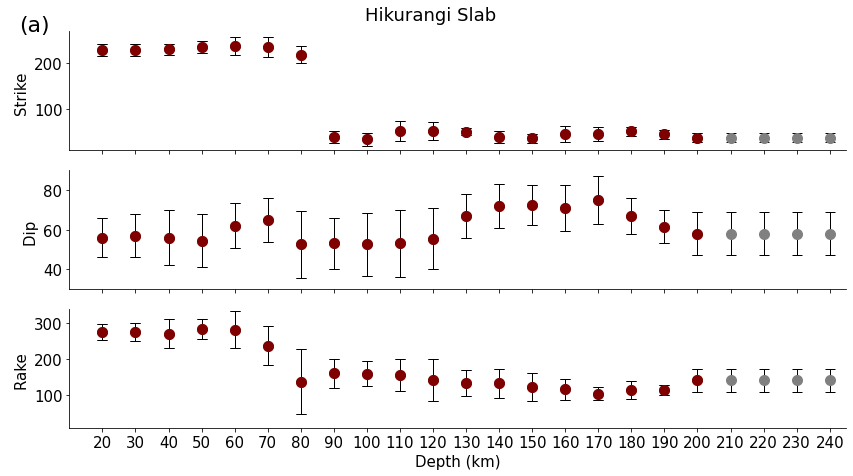

In [9]:
fmodel_hik, ifmodel_hik = get_fmodel('hik', slabevents);
plt.matplotlib.rcParams.update({'font.size': 15})
ax = plot_fmodel('hik', fmodel_hik, ifmodel_hik)
axin1 = ax.inset_axes([-0.08, .99, 0.15, 0.15])
axin1.text(0.1,0.1, '(a)', fontsize=22);
axin1.axis('off');
plt.savefig('Figure10A.jpeg', dpi=300, facecolor='w');

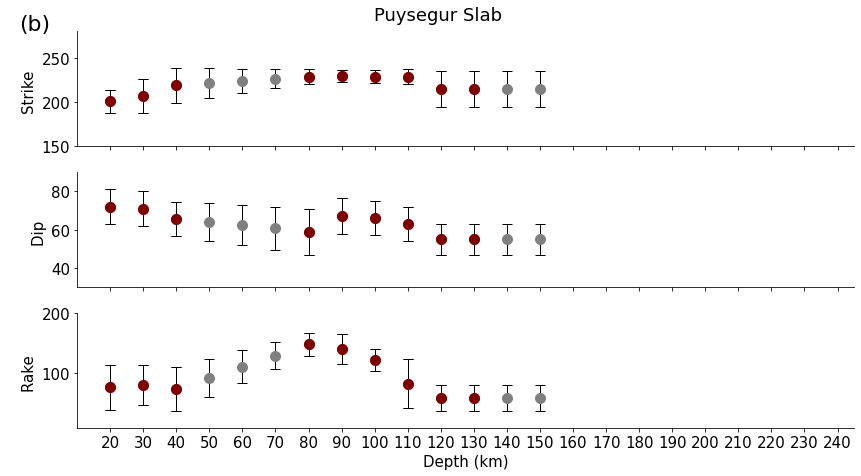

In [10]:
fmodel_puy, ifmodel_puy = get_fmodel('puy', slabevents);
for k in ifmodel_puy.keys():
    if k>150:
        ifmodel_puy[k]['strike'] = [float('nan'), float('nan')]
        ifmodel_puy[k]['dip'] = [float('nan'), float('nan')]
        ifmodel_puy[k]['rake'] = [float('nan'), float('nan')]

plt.matplotlib.rcParams.update({'font.size': 15})
ax = plot_fmodel('puy', fmodel_puy, ifmodel_puy)
axin1 = ax.inset_axes([-0.09, 1, 0.15, 0.15])
axin1.text(0.1,0.1, '(b)', fontsize=22);
axin1.axis('off');

plt.savefig('Figure10B.jpeg', dpi=300, facecolor='w');

In [11]:
# assmeble the faulting model
# {20: [[197, 59.0, -90, 0.32], [229, 59.0, -90, 0.36], [261, 59.0, -90, 0.32]],
import math

def get_slabrupgeom(kfmodel, maxdepth=9999):
    slabrupgeom = {}
    
    for db in kfmodel.keys():
        if db>maxdepth:
            continue
        strike = kfmodel[db]['strike'][0]
        strike_mad = kfmodel[db]['strike'][1]
        dip = round(kfmodel[db]['dip'][0],1)
        rake = kfmodel[db]['rake'][0]
        if math.isnan(rake):
            continue
        rake = round((rake + 180) % 360 - 180) # within +180 to -180
        sdrp1 = [strike, dip, rake, 0.36]
        sdrp0 = [round(circ_diff(strike,strike_mad)), dip, rake, 0.32]
        sdrp2 = [round(circ_add(strike,strike_mad)), dip, rake, 0.32]
        
        slabrupgeom.update({db: [sdrp0,sdrp1,sdrp2]})
    return slabrupgeom

#
slabrupgeom_hik = get_slabrupgeom(ifmodel_hik)
slabrupgeom_puy = get_slabrupgeom(ifmodel_puy)

slabrupgeom = {'hik': slabrupgeom_hik, 'puy': slabrupgeom_puy}

import json

with open("slab-faulting2.json", "w") as f:
    json.dump(slabrupgeom, f) 
    
print(slabrupgeom)

{'hik': {20: [[-144, 56.0, -85, 0.32], [229.0, 56.0, -85, 0.36], [242, 56.0, -85, 0.32]], 30: [[-143, 57.0, -84, 0.32], [230.0, 57.0, -84, 0.36], [243, 57.0, -84, 0.32]], 40: [[-141, 56.0, -89, 0.32], [231.0, 56.0, -89, 0.36], [243, 56.0, -89, 0.32]], 50: [[-138, 54.5, -76, 0.32], [235.5, 54.5, -76, 0.36], [248, 54.5, -76, 0.32]], 60: [[-140, 62.0, -78, 0.32], [239.0, 62.0, -78, 0.36], [258, 62.0, -78, 0.32]], 70: [[-145, 65.0, -123, 0.32], [236.0, 65.0, -123, 0.36], [257, 65.0, -123, 0.32]], 80: [[-160, 52.5, 138, 0.32], [219.0, 52.5, 138, 0.36], [238, 52.5, 138, 0.32]], 90: [[26, 53.0, 161, 0.32], [38.5, 53.0, 161, 0.36], [52, 53.0, 161, 0.32]], 100: [[20, 52.5, 160, 0.32], [34.0, 52.5, 160, 0.36], [48, 52.5, 160, 0.32]], 110: [[31, 53.0, 156, 0.32], [53.0, 53.0, 156, 0.36], [75, 53.0, 156, 0.32]], 120: [[32, 55.5, 142, 0.32], [52.5, 55.5, 142, 0.36], [73, 55.5, 142, 0.32]], 130: [[43, 67.0, 134, 0.32], [51.0, 67.0, 134, 0.36], [59, 67.0, 134, 0.32]], 140: [[26, 72.0, 133, 0.32], [39